# Location of the dataset in the Google Drive

### *Prefer to use Google Colaboratory to run the notebook hassle free*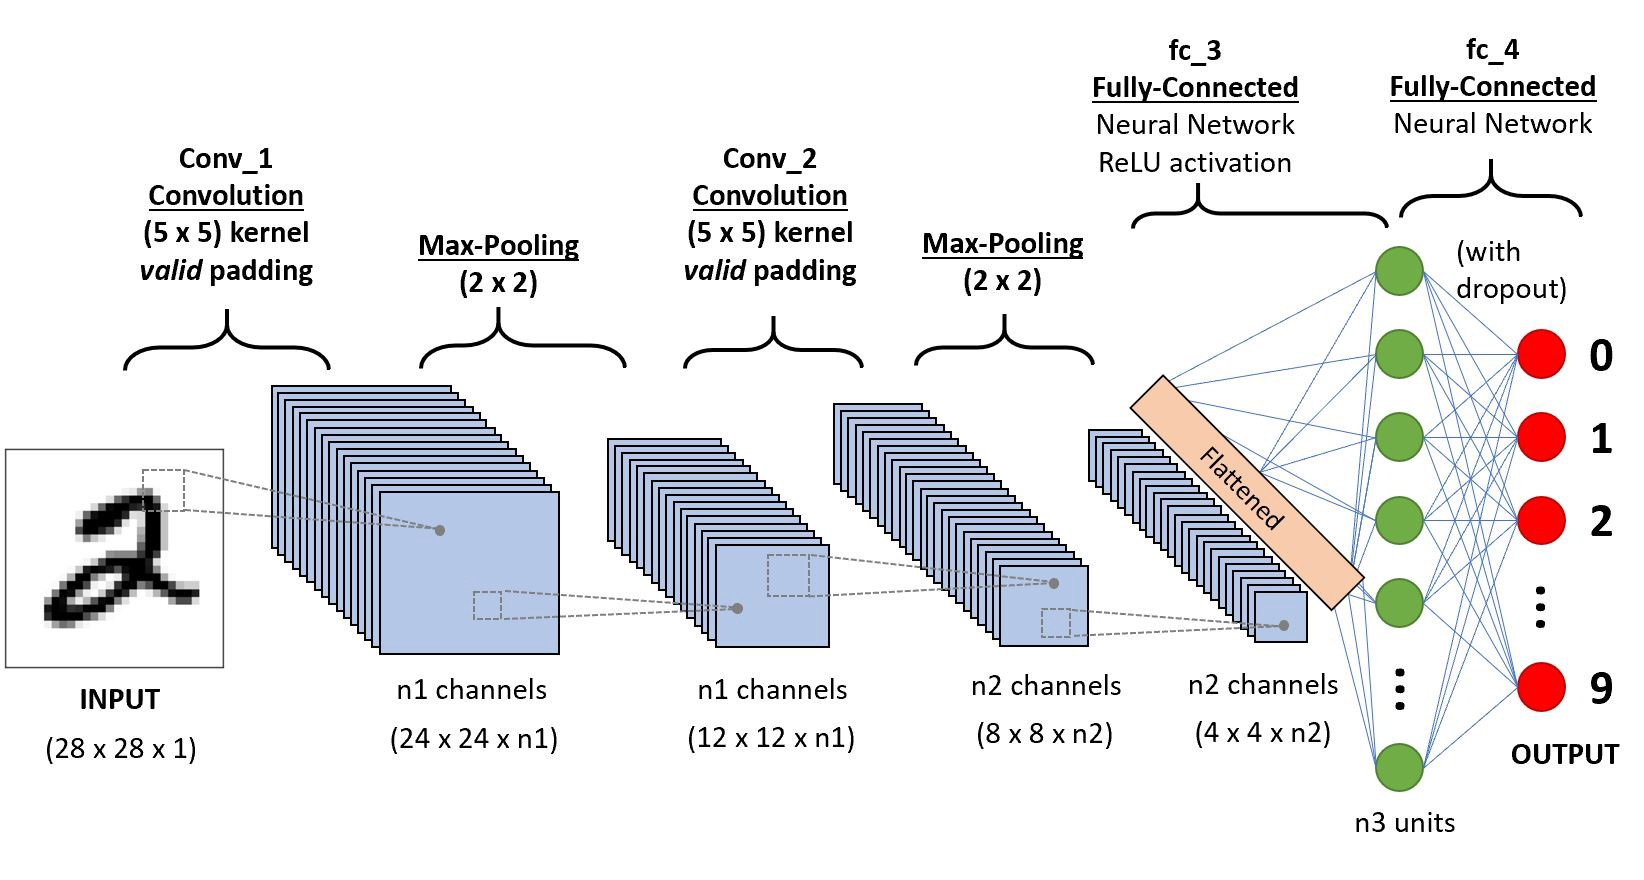

In [ ]:
# /content/drive/MyDrive/realvsfakeus

# Installing the required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Setting the image fixed size for training and intializing the batch size, channel and number of epochs

In [ ]:
Image_Size= 256
Batch_Size = 32
Channels=3
Epochs=55

## Determining number of pics and classes

In [ ]:
imgdata = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/realvsfakeus",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size

)

Found 2041 files belonging to 2 classes.


## This code creates a dataset of images using the Keras utility function image_dataset_from_directory.

### It reads images from a specified directory and organizes them into batches for training or validation.

### Here’s what each parameter means:


1.   This is the path to the directory containing your image data.
2.   The function will look for subdirectories within this path, where each subdirectory corresponds to a different class or label (e.g., “real” and “fake” faces).
3. Images in each subdirectory will be treated as examples of that class.












In [ ]:
class_names = imgdata.class_names
class_names  # 0 means fake and 1 means real

['fake', 'real']

## The below code iterates over the first batch of data from the dataset.
1. The take(1) method ensures that only one batch is retrieved.
2. Each batch contains a set of images and their corresponding labels.
3. The .numpy() method converts the labels from TensorFlow tensors to NumPy arrays for easier printing.
4. The labels correspond to the class names (“fake” or “real”) associated with each image

In [ ]:
for image_batch, label_batch in imgdata.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1]


## Displaying our first image

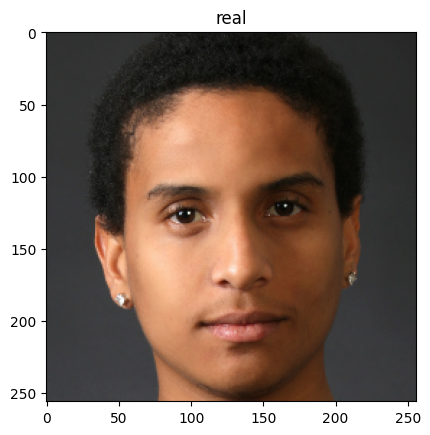

In [ ]:
for image_batch, label_batch in imgdata.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

# Function to create dataset

In [ ]:
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size=len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split * ds_size)
    val_size= int(val_split * ds_size)

    train_ds= ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=splitting_dataset_tf(imgdata)

In [ ]:
print(len(train_ds),len(val_ds),len(test_ds))

51 6 7


#  Pipeline for Optimization for Training, Validation, and Testing Datasets

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Image Preprocessing for Resizing and Rescaling

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data augmentation

In [ ]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

# Architecture of the model


1. input_shape: This defines the format of the input image data. It specifies a batch size, image size (height and width), and number of channels (usually 3 for RGB images).
2. n_classes: This indicates the number of output classes the model will predict. In this case, there are 3 classes, likely representing "real", "fake", and potentially an "uncertain" category.

### Model Layers:
1. The model uses a sequential architecture, stacking layers one after another:
2. resize_and_rescale (function not shown): This likely preprocesses the input images by resizing them to a standard size and potentially rescaling the pixel values.
3. data_aug (function not shown): This might be for data augmentation, which involves creating variations of the original images (e.g., flips, rotations) to improve the model's ability to generalize.
4. Convolutional Layers: These layers extract features from the image. There are six convolutional layers, each with:
5. 32 or 64 filters: These filters learn to detect specific patterns in the image.
6. Kernel size of (3,3): This defines the size of the area the filter scans over the image.
7. relu activation: This adds non-linearity to the model's predictions.
8. Pooling Layers: These layers reduce the dimensionality of the data and potentially capture higher-level features. There are six max pooling layers, each with a kernel size of (2,2).
9. Flatten Layer: This transforms the 2D feature maps from the convolutional layers into a 1D vector.
10. Dense Layers: These are fully-connected layers that learn more complex relationships between the features.
11. First dense layer has 64 units with relu activation.
12. Second dense layer has n_classes units (likely 3) with softmax activation. Softmax ensures the output probabilities for all classes sum to 1



In [ ]:
input_shape = (Batch_Size,Image_Size, Image_Size,Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),


    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),

])

model.build(input_shape=input_shape)

# Compiling the model with loss function and optimizer


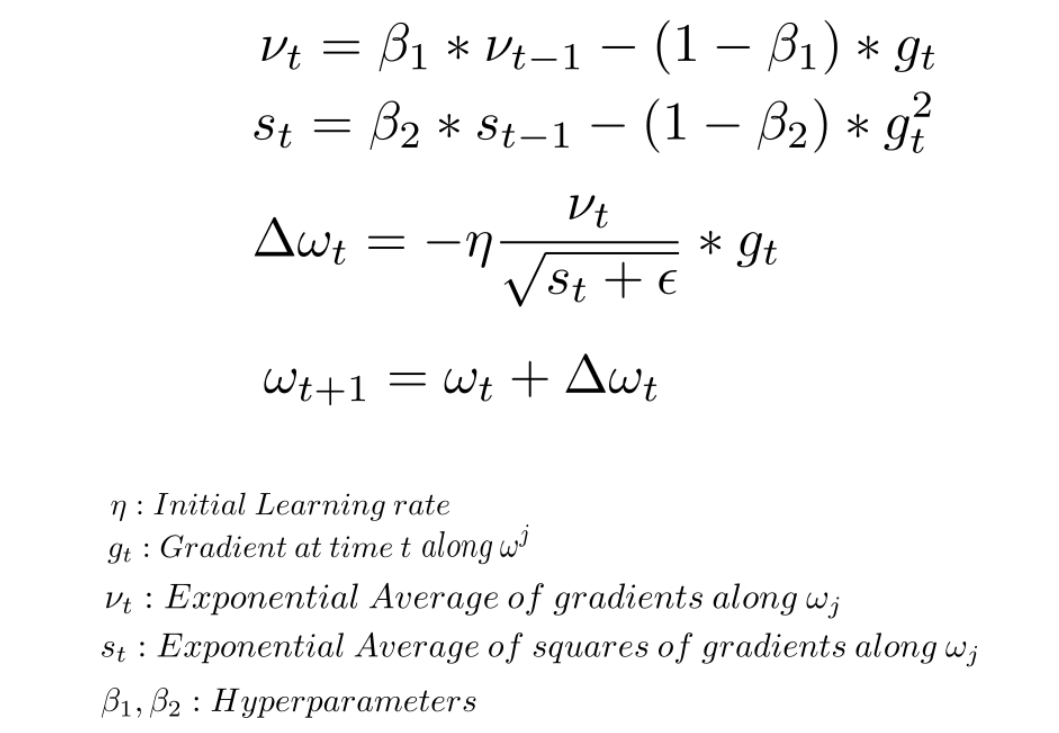

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Training with Training and Validation Data

In [ ]:
history = model.fit(
    train_ds,
    epochs=275,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/275
51/51 [==============================] - 238s 80ms/step - loss: 0.7425 - accuracy: 0.4798 - val_loss: 0.7070 - val_accuracy: 0.4657
Epoch 2/275
51/51 [==============================] - 4s 84ms/step - loss: 0.6985 - accuracy: 0.5159 - val_loss: 0.7510 - val_accuracy: 0.5343
Epoch 3/275
51/51 [==============================] - 4s 78ms/step - loss: 0.6983 - accuracy: 0.5190 - val_loss: 0.7012 - val_accuracy: 0.5343
Epoch 4/275
51/51 [==============================] - 4s 76ms/step - loss: 0.7018 - accuracy: 0.5172 - val_loss: 0.6968 - val_accuracy: 0.4675
Epoch 5/275
51/51 [==============================] - 4s 84ms/step - loss: 0.6987 - accuracy: 0.4933 - val_loss: 0.7091 - val_accuracy: 0.4657
Epoch 6/275
51/51 [==============================] - 4s 77ms/step - loss: 0.6957 - accuracy: 0.5263 - val_loss: 0.6924 - val_accuracy: 0.5343
Epoch 7/275
51/51 [==============================] - 4s 77ms/step - loss: 0.6963 - accuracy: 0.5031 - val_loss: 0.6940 - val_accuracy: 0.5343
Epoc

# checking the accuracy of the model


In [ ]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 1s 23ms/step - loss: 0.1868 - accuracy: 0.9265


### accuracy of the model is 92.65%

# predicting labels for the batch of images

first image to predict
Actual label :  real
1/1 [==============================] - 0s 141ms/step
Pred label :  real


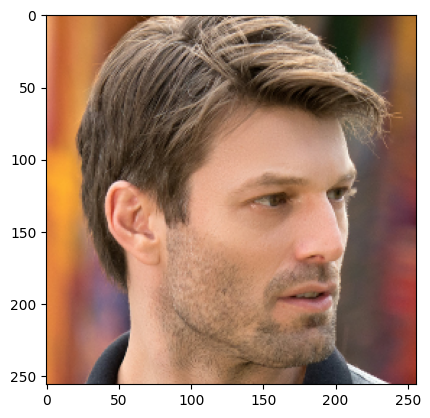

In [ ]:
import numpy as np

for image_batch, label_batch in imgdata.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label : ",class_names[first_label])


    batch_pred = model.predict(image_batch)
    print("Pred label : ",class_names[np.argmax(batch_pred[0])])

# image prediction function using the model


In [ ]:
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Displaying Sample Predictions with Confidence


1/1 [==============================] - 0s 28ms/step


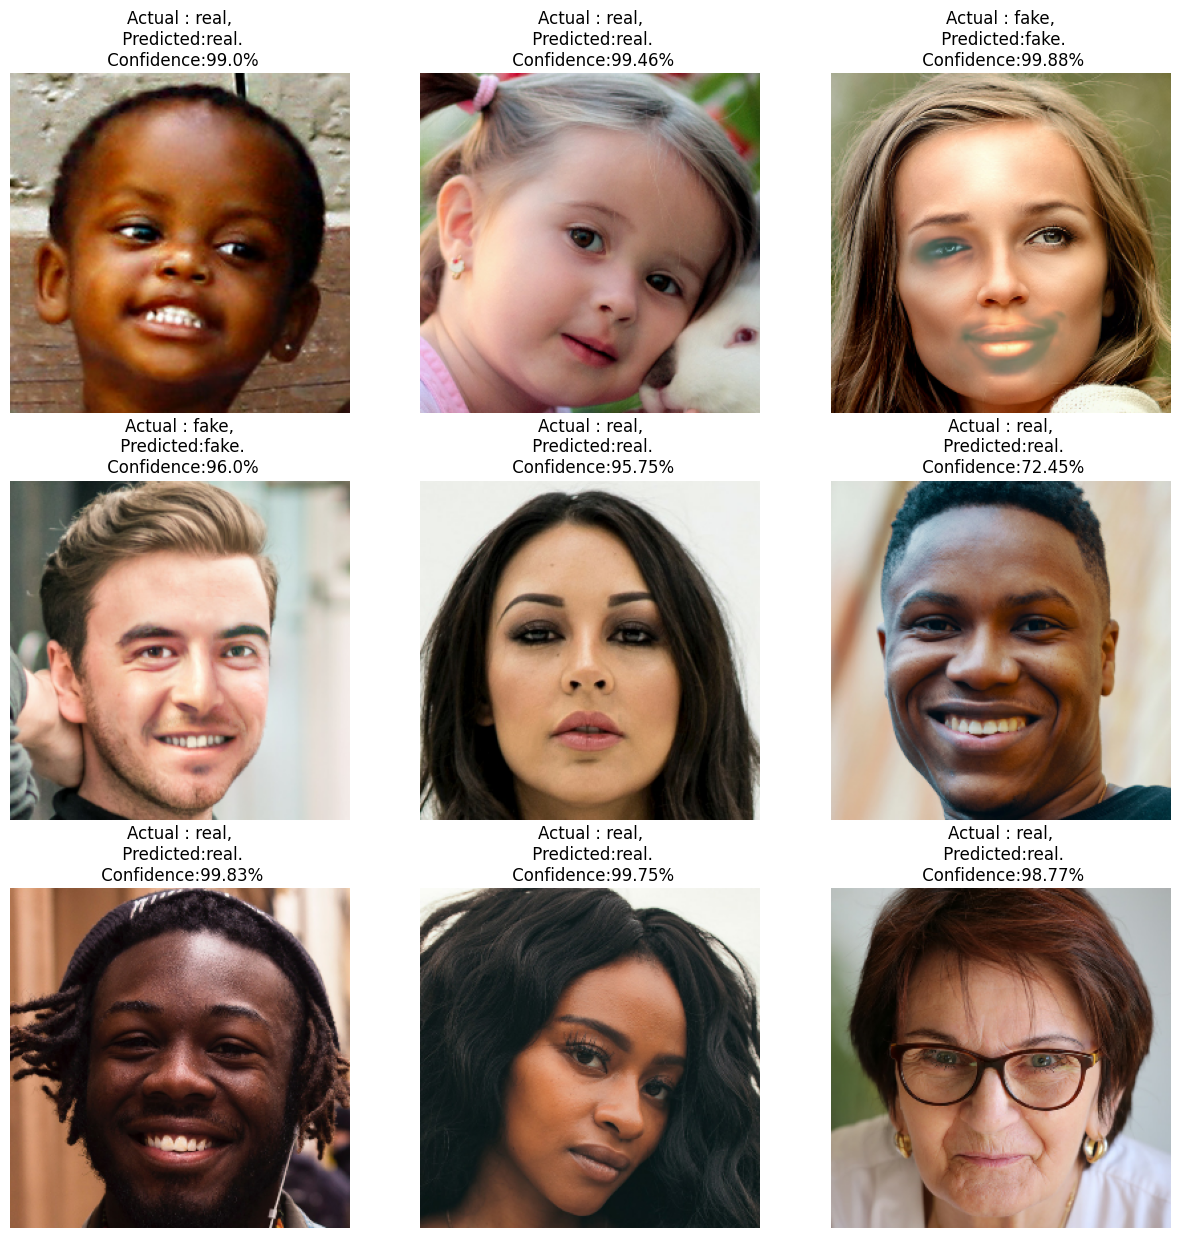

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = pred(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

# saving the model


In [ ]:
import pickle

with open('model_f_real_pickle_final','wb') as f:
  pickle.dump(model,f)


In [ ]:
# to run the pickle(saved model)
# import pickle

with open('model_f_real_pickle_final','rb') as f:
  model_saved = pickle.load(f)

#to predict the model
#model_saved.predict("give input")

1/1 [==============================] - 0s 100ms/step


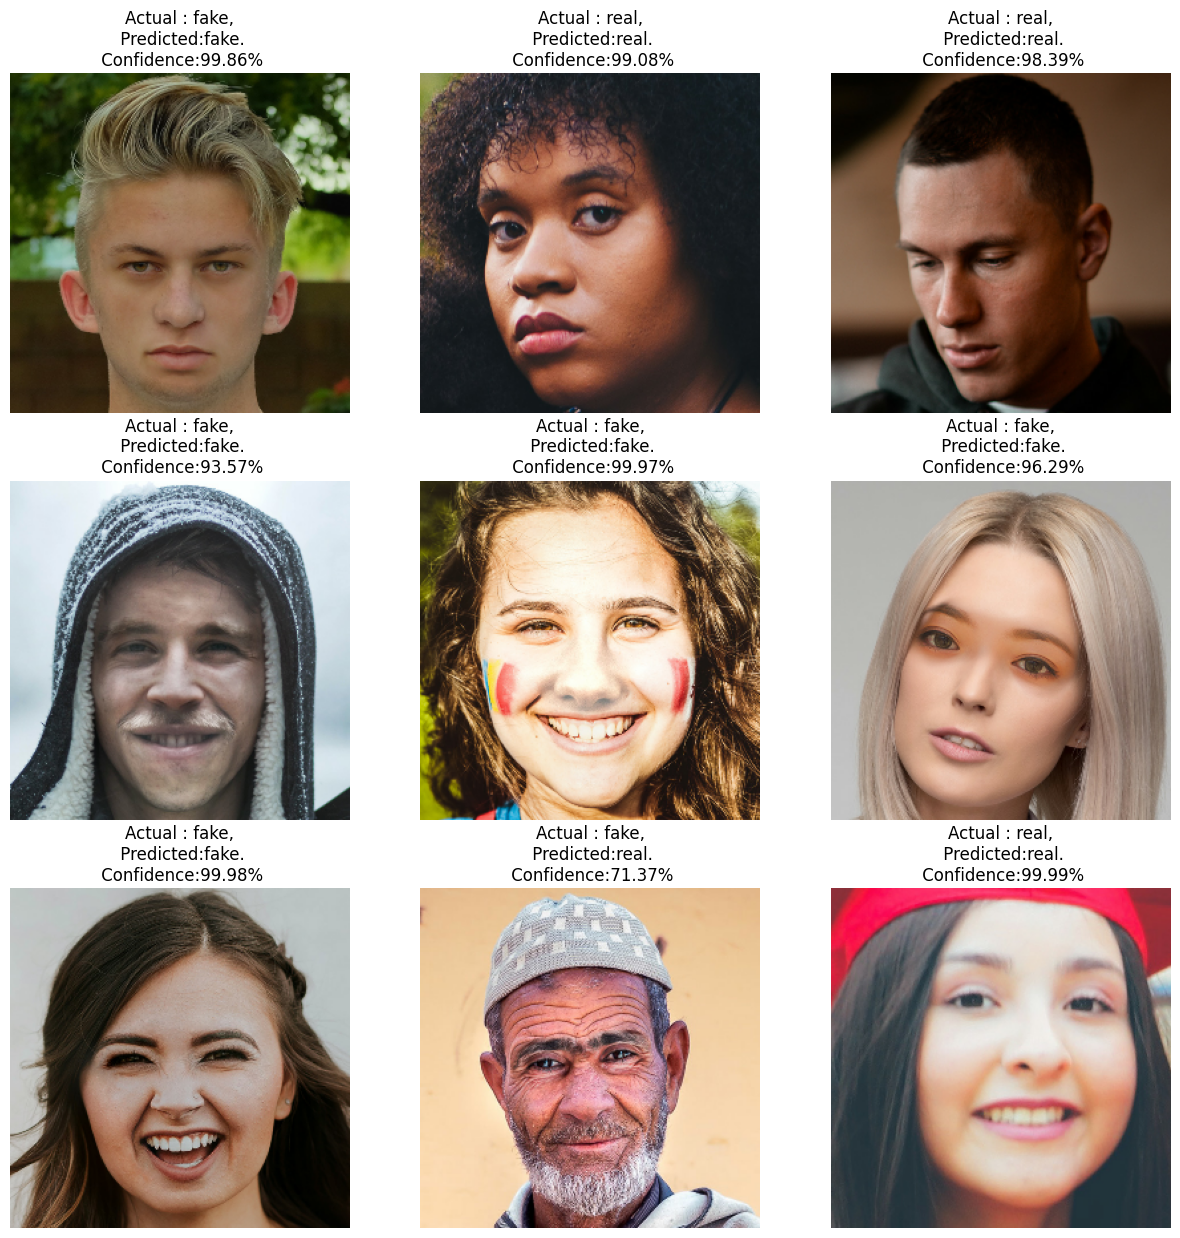

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = pred(model_saved, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")